# Worksheet

[FORM](https://forms.gle/fNezueqNgwqLu3iM8)

## Linear Model Evaluation

Notice that R^2 only increases with the number of explanatory variables used. Hence the need for an adjusted R^2 that penalizes for insignificant explanatory variables.

In [2]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

SAMPLE_SIZE = 100
beta = [1, 5]
X = -10.0 + 10.0 * np.random.random(SAMPLE_SIZE)
Y = beta[0] + beta[1] * X + np.random.randn(SAMPLE_SIZE)

for i in range(1, 15):
    X_transform = PolynomialFeatures(degree=i, include_bias=False).fit_transform(X.reshape(-1, 1))
    model = LinearRegression()
    model.fit(X_transform, Y)
    print(model.score(X_transform, Y))

0.9947127958804232
0.994742668284361
0.9947998826693228
0.9948608423270133
0.994873605321043
0.9950249449602157
0.995232422560491
0.995334720277052
0.9953577931172739
0.9955182299811218
0.9956921854669327
0.9958103037753033
0.9957102299369952
0.995473533682855


## Simulate and Count

What is the probability that a fair coin generated this sequence of coin tosses.

Dataset of coin tosses:  [np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0)]
Probability that a fair coin generates it:  0.31249999999999994

We simulated a fair coin being flipped 6 times.
In our 1000 simulations, this was the count of the number of Heads (out of 6) we observed: 


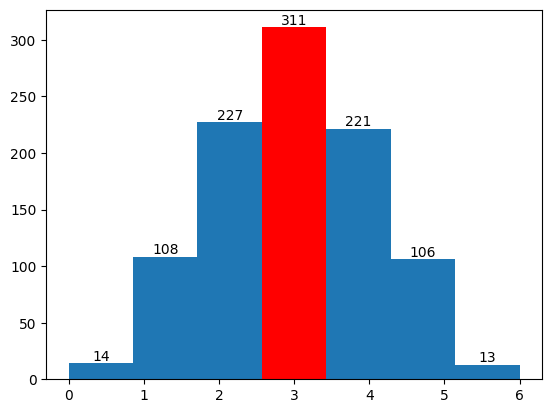

In [3]:
import numpy as np
from scipy.stats import binom
import matplotlib.pyplot as plt

def num_successes(flips):
    return sum(flips)

SAMPLE_SIZE = 6
og_flips = [np.random.choice([0, 1]) for _ in range(SAMPLE_SIZE)]
print("Dataset of coin tosses: ", og_flips)
print("Probability that a fair coin generates it: ", binom.pmf(num_successes(og_flips), SAMPLE_SIZE, 1/2))
print()

p_est = []
NUM_SIMULATIONS = 1000

print("We simulated a fair coin being flipped "
      + str(SAMPLE_SIZE)
      + " times.\nIn our "
      + str(NUM_SIMULATIONS)
      + " simulations, this was the count of the number of Heads (out of 6) we observed: "
    )

for _ in range(NUM_SIMULATIONS):
    flips = [np.random.choice([0, 1]) for _ in range(SAMPLE_SIZE)]
    p_est.append(num_successes(flips))

fig, ax = plt.subplots()
_, bins, patches = ax.hist(p_est, bins=SAMPLE_SIZE + 1)
p = np.digitize([num_successes(og_flips)], bins)
patches[p[0]-1].set_facecolor('r')
ax.bar_label(patches)
plt.show()


In Linear Regression, our most pressing question is whether there is in fact a true relationship between our predictors `X` and our target `y` - or if the relationship we observed was just a fluke.

Through simulations and counting, let's see just how likely or unlikely it is to observe linear relationships in data that was generated by an `X` and `y` that are not linearly related.

True beta =  [0 0]
Observed beta =  [-0.28777424 -0.32436241]


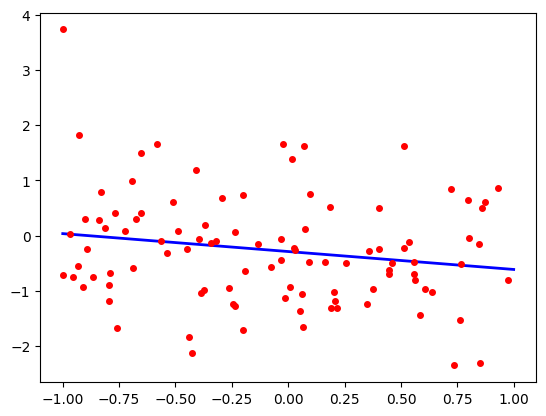

In [4]:
import numpy as np
import matplotlib.pyplot as plt

SAMPLE_SIZE = 100

xlin = -1.0 + 2.0 * np.random.random(SAMPLE_SIZE)
y = 0.0 * xlin + np.random.randn(SAMPLE_SIZE) # beta = 0 means there is no relationship between x and y.

intercept = np.ones(np.shape(xlin)[0])
X = np.array([intercept, xlin]).T
beta = np.linalg.inv(X.T @ X) @ X.T @ y

print("True beta = ", np.array([0, 0]))
print("Observed beta = ", beta)

xplot = np.linspace(-1,1,20)
yestplot = beta[0] + beta[1] * xplot
plt.plot(xplot, yestplot,'b-',lw=2)
plt.plot(xlin, y,'ro',markersize=4)
plt.show()

Lets see what happens if we repeat this 1000 times and record the estimated intercept and slope each time to plot them in a histogram.

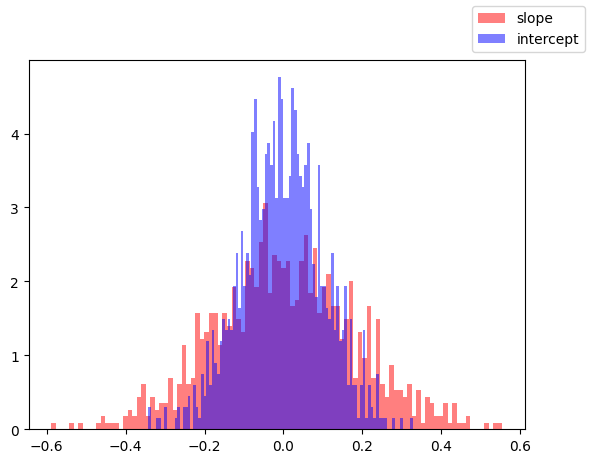

In [5]:
NUM_TRIALS = 1000
inter = []
slope = []
for _ in range(NUM_TRIALS):

    xlin = -1.0 + 2.0 * np.random.random(SAMPLE_SIZE)
    y = 0.0 * xlin + np.random.randn(SAMPLE_SIZE)

    intercept = np.ones(np.shape(xlin)[0])
    X = np.array([intercept, xlin]).T
    beta = np.linalg.inv(X.T @ X) @ X.T @ y
    inter.append(beta[0])
    slope.append(beta[1])

fig, ax = plt.subplots()
ax.hist(slope, bins=100, density=True, color='r', alpha=.5, label="slope")
ax.hist(inter, bins=100, density=True, color='b', alpha=.5, label="intercept")
fig.legend()
plt.show()

If we then encountered a dataset of size 100 as above and the slope was say 2, we would have a lot of evidence / reasonable grounds to say that most likely this dataset was NOT generated with a true slope of 0.

Running these simulations can be expensive sometimes so computing these probabilities directly (instead of through simulations) would be nice. What we want to know is: given a true beta, what is the probability of observing a range of estimated betas on a dataset of a specific size N.

Lets take this one step at a time.

## Computing Probabilities

We know that:

$$\hat\beta-\beta \sim \mathcal{N}(0,\sigma^2 (X^TX)^{-1})$$

thus for each component $k$ of $\hat\beta$ (here there are only two - one slope and one intercept)

$$\hat\beta_k -\beta_k \sim \mathcal{N}(0, \sigma^2 S_{kk})$$

where $S_{kk}$ is the $k^\text{th}$ diagonal element of $(X^TX)^{-1}$. Thus, we know that 

$$z_k = \frac{\hat\beta_k -\beta_k}{\sqrt{\sigma^2 S_{kk}}} \sim \mathcal{N}(0,1)$$

Verify that this is the case through a simulation and compare it to the standard normal pdf by plotting it on top of the histogram.

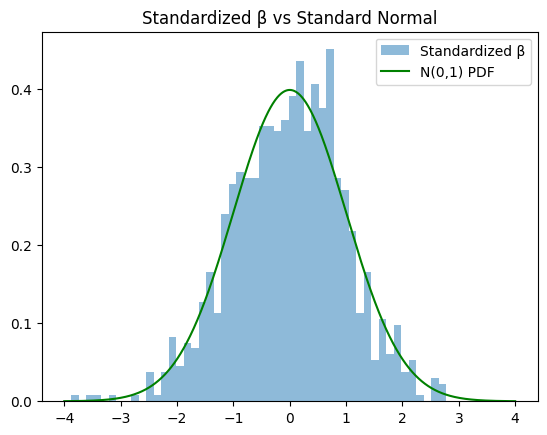

In [7]:
from scipy.stats import norm

beta_hist = []
for _ in range(1000):
    # Generate data
    xlin = -1.0 + 2.0 * np.random.random(SAMPLE_SIZE)
    y = 0.0 * xlin + np.random.randn(SAMPLE_SIZE)  # sigma = 1
    
    # Create design matrix
    intercept = np.ones(np.shape(xlin)[0])
    X = np.array([intercept, xlin]).T
    
    # Calculate beta hat
    beta = np.linalg.inv(X.T @ X) @ X.T @ y
    
    # Calculate S_kk (we'll use k=1 for the slope)
    S = np.linalg.inv(X.T @ X)
    S_kk = S[1,1]  # for the slope coefficient
    
    # Calculate standardized beta (z-score)
    # We know true beta is 0 and sigma is 1
    z = beta[1] / np.sqrt(S_kk)
    beta_hist.append(z)

xs = np.linspace(-4, 4, 1000)
fig, ax = plt.subplots()
ax.hist(beta_hist, bins=50, density=True, alpha=0.5, label='Standardized β')
ax.plot(xs, norm.pdf(xs, loc=0, scale=1), color='green', label='N(0,1) PDF')
ax.set_title('Standardized β vs Standard Normal')
ax.legend()
plt.show()

#### FORM Q1

Use the CDF of a standard normal distribution, to provide the probability that the following dataset's true slope is greater than 0. Assume that $\sigma^2 = 1$

0.5343081689853529


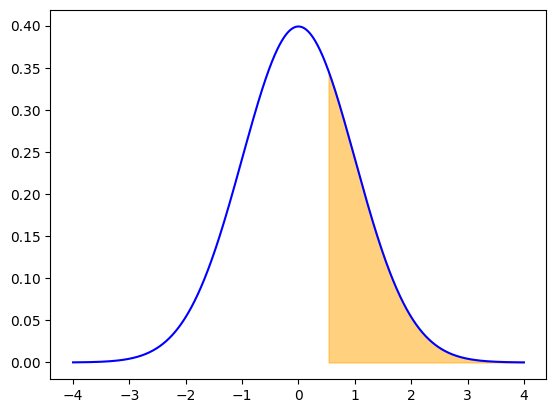

In [8]:
from scipy.stats import norm

x = np.array([-0.1920605, -0.11290798, -0.56434374, -0.67052057, -0.19233284, -0.42403586, -0.8114285, -0.38986946, -0.37384161, -0.50930229])
y = np.array([-0.34063108, -0.33409286, 0.34245857, 0.11062295, 0.76682389, 0.86592388, -1.68912015, -2.01463592, 1.61798563, 0.60557414])

intercept = np.ones(np.shape(x)[0])
X = np.array([intercept, x]).T
beta_hat = np.linalg.inv(X.T @ X) @ X.T @ y

z = beta_hat[1]/((X.T @ X)[1][1])
print(z)

x = np.linspace(-4, 4, 1000)
pdf = norm.pdf(x, loc=0, scale=1)

fig, ax = plt.subplots()
ax.plot(x, pdf, color="blue")
x_fill = np.linspace(z, 4, 1000)
pdf_fill = norm.pdf(x_fill, loc=0, scale=1)
ax.fill_between(x_fill, pdf_fill, color="orange", alpha=0.5, label=f"Area to the right of {z}")
plt.show()

In practice we don't know the standard deviation and need to use an unbiased estimate of the standard deviation instead. This estimate is the standard error `s`

$$s = \sqrt{\frac{RSS}{n - p}}$$

where p is the number of parameters beta (here there are 2 - one slope and one intercept). This normalized $\hat\beta$ can be shown to follow a t-distribution with `n-p` degrees of freedom. Verify this is the case with a simulation.

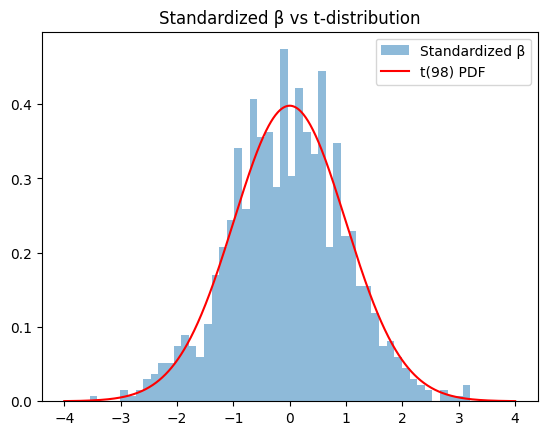

In [9]:
from scipy.stats import t

def standard_error(ytrue, ypred):
    residuals = ytrue - ypred
    n = len(ytrue)
    p = 2  # number of parameters (intercept and slope)
    return np.sqrt(np.sum(residuals**2) / (n - p))

SAMPLE_SIZE = 100
beta_hist = []
for _ in range(1000):
    # Generate data
    xlin = -1.0 + 2.0 * np.random.random(SAMPLE_SIZE)
    y = 0.0 * xlin + np.random.randn(SAMPLE_SIZE)
    
    # Create design matrix
    intercept = np.ones(np.shape(xlin)[0])
    X = np.array([intercept, xlin]).T
    
    # Calculate beta hat
    beta = np.linalg.inv(X.T @ X) @ X.T @ y
    
    # Calculate predicted values
    y_pred = X @ beta
    
    # Calculate standard error
    s = standard_error(y, y_pred)
    
    # Calculate S_kk (for slope coefficient)
    S = np.linalg.inv(X.T @ X)
    S_kk = S[1,1]
    
    # Calculate t-statistic
    t_stat = beta[1] / (s * np.sqrt(S_kk))
    beta_hist.append(t_stat)

xs = np.linspace(-4, 4, 1000)
fig, ax = plt.subplots()
ax.hist(beta_hist, bins=50, density=True, alpha=0.5, label='Standardized β')
ax.plot(xs, t.pdf(xs, df=SAMPLE_SIZE-2), color='red', label=f't({SAMPLE_SIZE-2}) PDF')
ax.set_title('Standardized β vs t-distribution')
ax.legend()
plt.show()

#### FORM Q2

Use a t distribution to provide the probability that the following dataset's true slope is greater than 0

In [10]:
import numpy as np
from scipy.stats import t

# Data
x = np.array([-0.1920605, -0.11290798, -0.56434374, -0.67052057, -0.19233284, -0.42403586, 
              -0.8114285, -0.38986946, -0.37384161, -0.50930229])
y = np.array([-0.34063108, -0.33409286, 0.34245857, 0.11062295, 0.76682389, 0.86592388, 
              -1.68912015, -2.01463592, 1.61798563, 0.60557414])

# Design matrix X (intercept + x)
intercept = np.ones(np.shape(x)[0])
X = np.vstack([intercept, x]).T

# Estimate beta using OLS
beta_hat = np.linalg.inv(X.T @ X) @ X.T @ y

# Predicted values and residuals
y_pred = X @ beta_hat
residuals = y - y_pred

# Residual sum of squares (RSS) and degrees of freedom
RSS = np.sum(residuals**2)
n = len(y)  # Number of data points
p = 2  # Number of parameters (intercept + slope)

# Estimate the variance of residuals
sigma_squared = RSS / (n - p)

# Standard error of slope (beta_1)
XtX_inv = np.linalg.inv(X.T @ X)
SE_beta_1 = np.sqrt(sigma_squared * XtX_inv[1, 1])

# t-statistic for the slope (beta_1)
t_stat = beta_hat[1] / SE_beta_1

# Degrees of freedom for the t-distribution
df = n - p

# Calculate the probability that the true slope is greater than 0
# This is the upper tail of the t-distribution
p_value = 1 - t.cdf(t_stat, df)

# Output the results
print(f"Estimated slope (beta_1): {beta_hat[1]}")
print(f"Standard error of beta_1: {SE_beta_1}")
print(f"t-statistic for beta_1: {t_stat}")
print(f"Degrees of freedom: {df}")
print(f"Probability that the true slope is greater than 0: {p_value}")

Estimated slope (beta_1): 1.1990282719906202
Standard error of beta_1: 1.7523026381576574
t-statistic for beta_1: 0.6842586696389724
Degrees of freedom: 8
Probability that the true slope is greater than 0: 0.25657103604528764
